In [1]:
import numpy as np
from numpy import genfromtxt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import GPy

In [2]:
# loading the data.
path = r"C:\Users\mikep\Desktop\project\data\final"

Xtrain = genfromtxt(path+"\Xtrain.csv", delimiter=',', skip_header=1)
Xtest = genfromtxt(path+"\Xtest.csv", delimiter=',', skip_header=1)

Ytrain = genfromtxt(path+"\Ytrain.csv", delimiter=',', skip_header=1)
Ytest = genfromtxt(path+"\Ytest.csv", delimiter=',', skip_header=1)

Ytrain = np.array([Ytrain]).T
Ytest = np.array([Ytest]).T

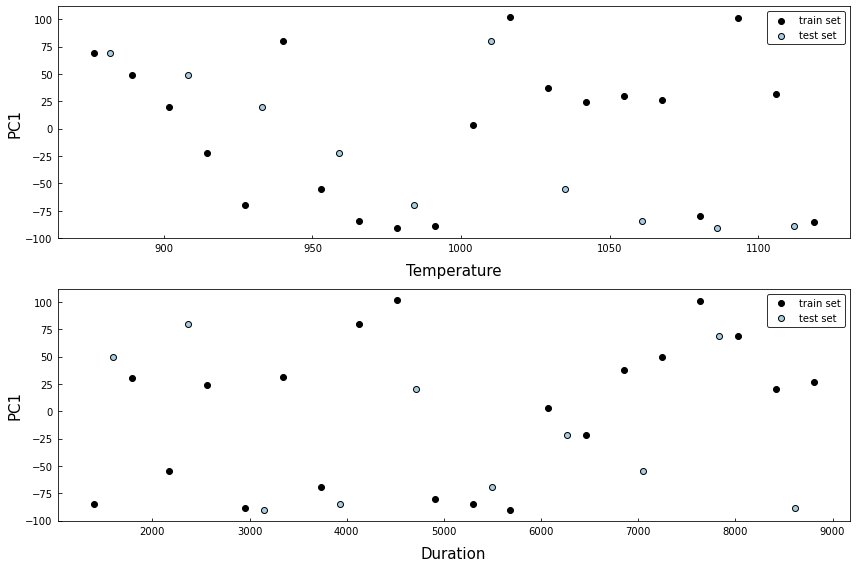

In [3]:
# visualizing the initial data

#plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(2, figsize=(12, 8))

ax[0].scatter(x = Xtrain[:,0], y = Ytrain, marker='o', c='black', edgecolor='black', label='train set')
ax[0].scatter(x = Xtest[:,0], y = Ytest, marker='o', c='#a6cee3', edgecolor='black', label='test set')

ax[0].set_xlabel("Temperature", fontsize=15, labelpad=10, horizontalalignment='center')
ax[0].set_ylabel("PC1", fontsize=15, labelpad=3, horizontalalignment='center')

ax[0].tick_params(axis='both', which='both', labelsize=10, direction="in", pad=5)
#ax[0].tick_params(labelbottom=False, size=4, )

ax[0].legend(loc='best', fontsize=10, edgecolor='black')

###====###

ax[1].scatter(x = Xtrain[:,1], y = Ytrain, marker='o', c='black', edgecolor='black', label='train set')
ax[1].scatter(x = Xtest[:,1], y = Ytest, marker='o', c='#a6cee3', edgecolor='black', label='test set')

ax[1].set_xlabel("Duration", fontsize=15, labelpad=10, horizontalalignment='center')
ax[1].set_ylabel("PC1", fontsize=15, labelpad=3, horizontalalignment='center')

ax[1].tick_params(axis='both', which='both', labelsize=10, direction="in", pad=5)

ax[1].legend(loc='best', fontsize=10, edgecolor='black')

###====###

plt.tight_layout()
#fig.savefig(r"C:\Users\mikep\Desktop\thesis\figures\data-visualization.png", facecolor='w', dpi=600)
plt.show()

In [4]:
# normalizing the input data /// standardizing the output data
norm_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

Xtrain = norm_scaler.fit_transform(Xtrain)
Xtest = norm_scaler.transform(Xtest)

Ytrain = standard_scaler.fit_transform(Ytrain)
Ytest = standard_scaler.transform(Ytest)

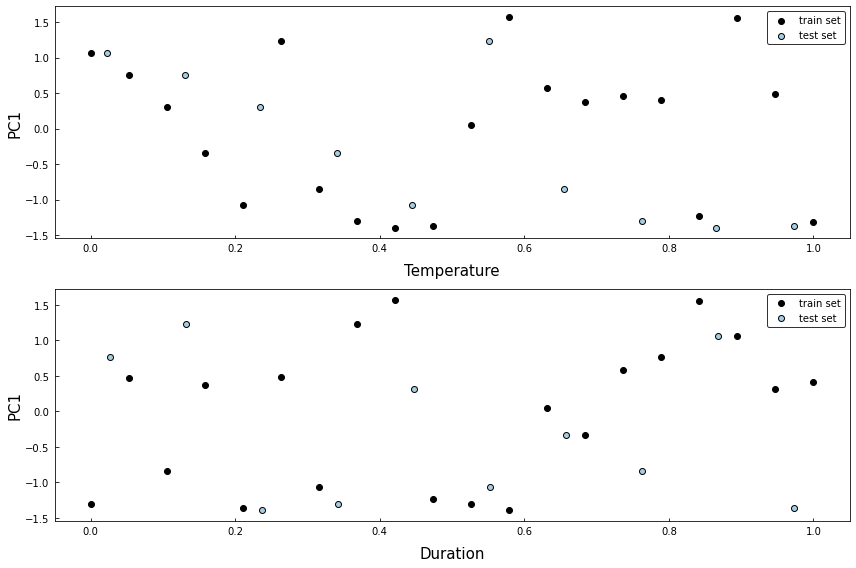

In [5]:
# visualizing the data

#plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(2, figsize=(12, 8))

ax[0].scatter(x = Xtrain[:,0], y = Ytrain, marker='o', c='black', edgecolor='black', label='train set')
ax[0].scatter(x = Xtest[:,0], y = Ytest, marker='o', c='#a6cee3', edgecolor='black', label='test set')

ax[0].set_xlabel("Temperature", fontsize=15, labelpad=10, horizontalalignment='center')
ax[0].set_ylabel("PC1", fontsize=15, labelpad=3, horizontalalignment='center')

ax[0].tick_params(axis='both', which='both', labelsize=10, direction="in", pad=5)
#ax[0].tick_params(labelbottom=False, size=4, )

ax[0].legend(loc='best', fontsize=10, edgecolor='black')

###====###

ax[1].scatter(x = Xtrain[:,1], y = Ytrain, marker='o', c='black', edgecolor='black', label='train set')
ax[1].scatter(x = Xtest[:,1], y = Ytest, marker='o', c='#a6cee3', edgecolor='black', label='test set')

ax[1].set_xlabel("Duration", fontsize=15, labelpad=10, horizontalalignment='center')
ax[1].set_ylabel("PC1", fontsize=15, labelpad=3, horizontalalignment='center')

ax[1].tick_params(axis='both', which='both', labelsize=10, direction="in", pad=5)

ax[1].legend(loc='best', fontsize=10, edgecolor='black')

###====###

plt.tight_layout()
#fig.savefig(r"C:\Users\mikep\Desktop\thesis\figures\data-visualization.png", facecolor='w', dpi=600)
plt.show()

In [10]:
# constructing some 2-D kernels by multiplying others

#our initial kernels
ks = [ 
    GPy.kern.StdPeriodic(2, active_dims=[0,1]),     # Periodicity (short term trend)
    GPy.kern.RBF(2, ARD=True),                      # Amplitude modulator (long term trend)
    ### =================================== ###
    GPy.kern.RBF(2),
    GPy.kern.Matern32(2, ARD=True),
    GPy.kern.Matern32(2)
]

# composite kernels
k = ks[0] * ks[1]   #main kernel

k1 = ks[0] * ks[2]
k2 = ks[0] * ks[3]
k3 = ks[0] * ks[4]

k

mul.,value,constraints,priors
std_periodic.variance,1.0,+ve,
std_periodic.period,1.0,+ve,
std_periodic.lengthscale,1.0,+ve,
rbf.variance,1.0,+ve,
rbf.lengthscale,"(2,)",+ve,


In [26]:
# function for kernel plotting

from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette("mako"))

def plot_kern(kernel):
    z = []
    x = []
    y = []
    
    n = np.linspace(-4, 4, 100)
    e0 = np.linspace(-4, 4, 100)
    
    for n_value in n:
        for e0_value in e0:
            x.append(n_value)
            y.append(e0_value)
            z.append(kernel.K(np.array([[n_value,e0_value],[1.,1.]]))[0][1])

    fig = plt.figure(figsize =(14, 9))
    ax = plt.axes(projection ='3d')

    ax.plot_trisurf(x, y, z,
                    linewidth = 1,
                    antialiased = True,
                    cmap=my_cmap);
    
    ax.set_xlabel('input $x_1$', fontsize=15)
    ax.set_ylabel('input $x_2$', fontsize=15)
    ax.set_zlabel('Covariance', fontsize=15)
    
    plt.tight_layout()
    #plt.savefig(r'C:\Users\mikep\Desktop\thesis\figures\optimized_kernel.png', facecolor='w', dpi=600)
    
    plt.show()

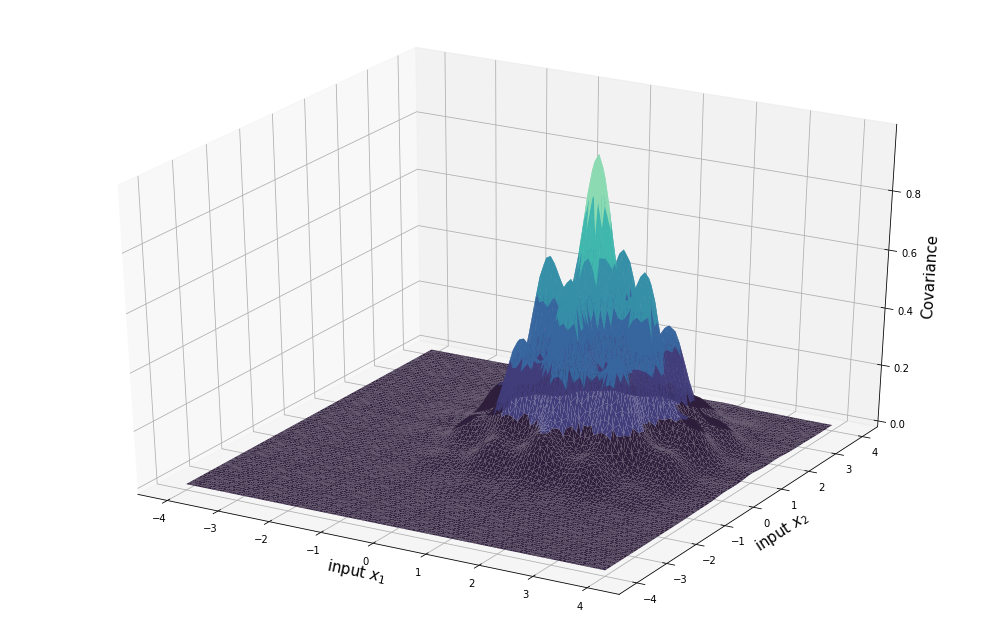

In [14]:
# plotting the initial kernel
plot_kern(k)

In [22]:
# specifying the model

m = GPy.models.GPRegression(Xtrain, Ytrain, k)   #main model

### ====================================== ###

m1 = GPy.models.GPRegression(Xtrain, Ytrain, k1)
m2 = GPy.models.GPRegression(Xtrain, Ytrain, k2)
m3 = GPy.models.GPRegression(Xtrain, Ytrain, k3)

models=[m, m1, m2, m3]
for model in models:
    model.Gaussian_noise.variance = 0.05
    model.Gaussian_noise.variance.fix()

print(m)
print(k.rbf.lengthscale)


Name : GP regression
Objective : 25.457873844191305
Number of Parameters : 7
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.                |                value  |  constraints  |  priors
  mul.std_periodic.variance     |    0.949997417292553  |      +ve      |        
  mul.std_periodic.period       |   0.5743800580828632  |      +ve      |        
  mul.std_periodic.lengthscale  |  0.29774487900282953  |      +ve      |        
  mul.rbf.variance              |   1.0087562600259075  |      +ve      |        
  mul.rbf.lengthscale           |                 (2,)  |      +ve      |        
  Gaussian_noise.variance       |                 0.05  |   +ve fixed   |        
  index  |  GP_regression.mul.rbf.lengthscale  |  constraints  |  priors
  [0]    |                     15806.00328505  |      +ve      |        
  [1]    |                      2389.19455653  |      +ve      |        


In [23]:
# optimization
m.optimize()
m.optimize_restarts(10, robust=True)

print(m)
print(k.rbf.lengthscale)

# optimizing the kernel parameters of the rest of the models
for model in models:
    model.optimize()
    model.optimize_restarts(5, robust=True)

Optimization restart 1/10, f = 25.45787384368622
Optimization restart 2/10, f = 27.31203720807526
Optimization restart 3/10, f = 27.718537043159007
Optimization restart 4/10, f = 37.522996714044915
Optimization restart 5/10, f = 28.37877066409345
Optimization restart 6/10, f = 27.312041902067914
Optimization restart 7/10, f = 27.70779580190277
Optimization restart 8/10, f = 27.69261692128944
Optimization restart 9/10, f = 25.45788457530874
Optimization restart 10/10, f = 28.221946122119995
Optimization restart 1/5, f = 25.457873843326347
Optimization restart 2/5, f = 27.312036907550343
Optimization restart 3/5, f = 25.45788370738304
Optimization restart 4/5, f = 25.457898636181
Optimization restart 5/5, f = 27.833535685949094
Optimization restart 1/5, f = 25.457876185542705
Optimization restart 2/5, f = 25.4578794483075
Optimization restart 3/5, f = 25.457876094496584
Optimization restart 4/5, f = 25.45787584871966
Optimization restart 5/5, f = 25.457947573165896
Optimization restart 1

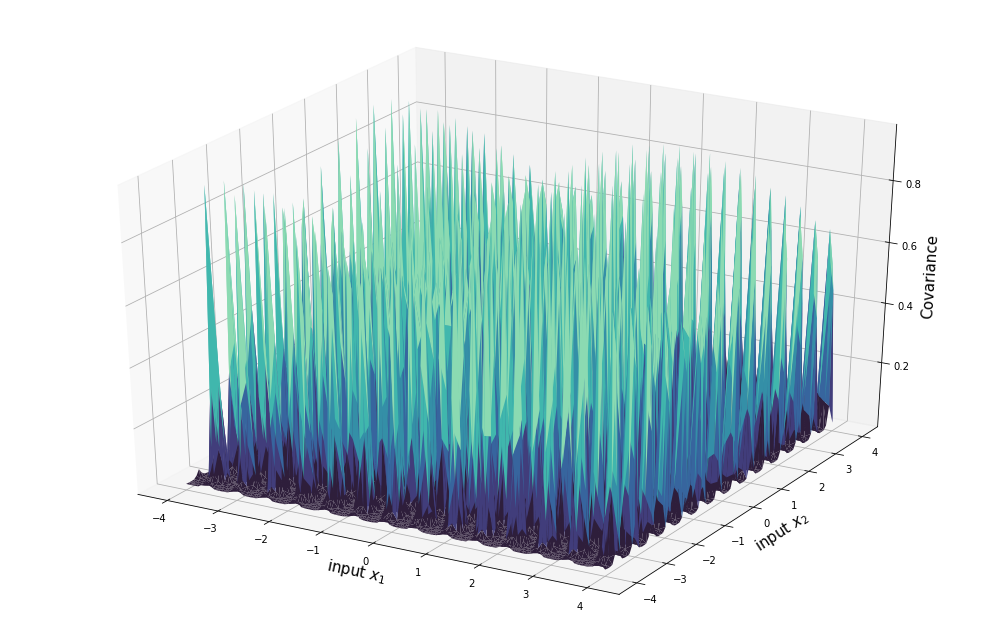

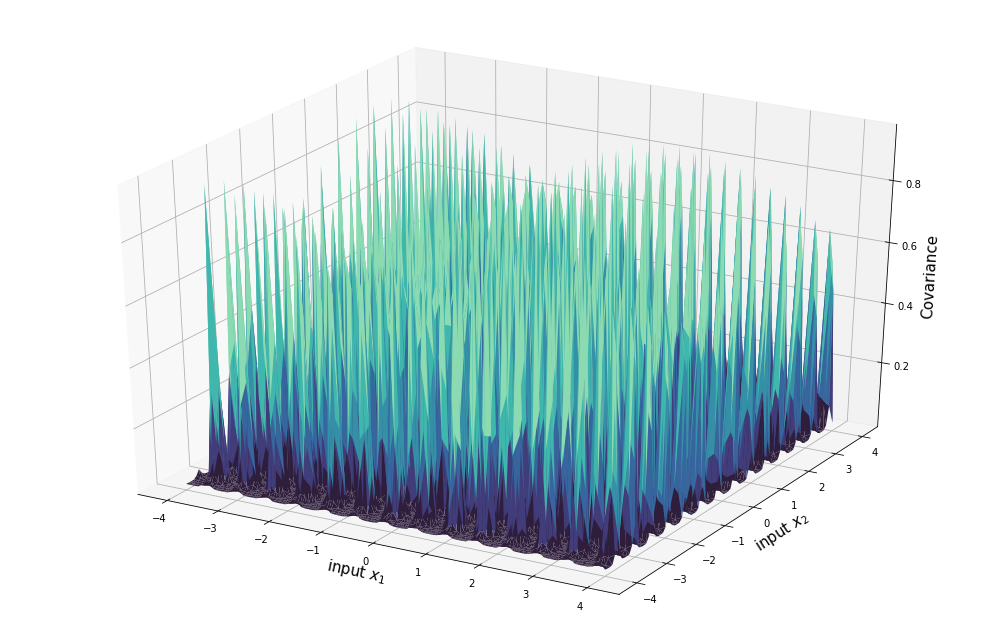

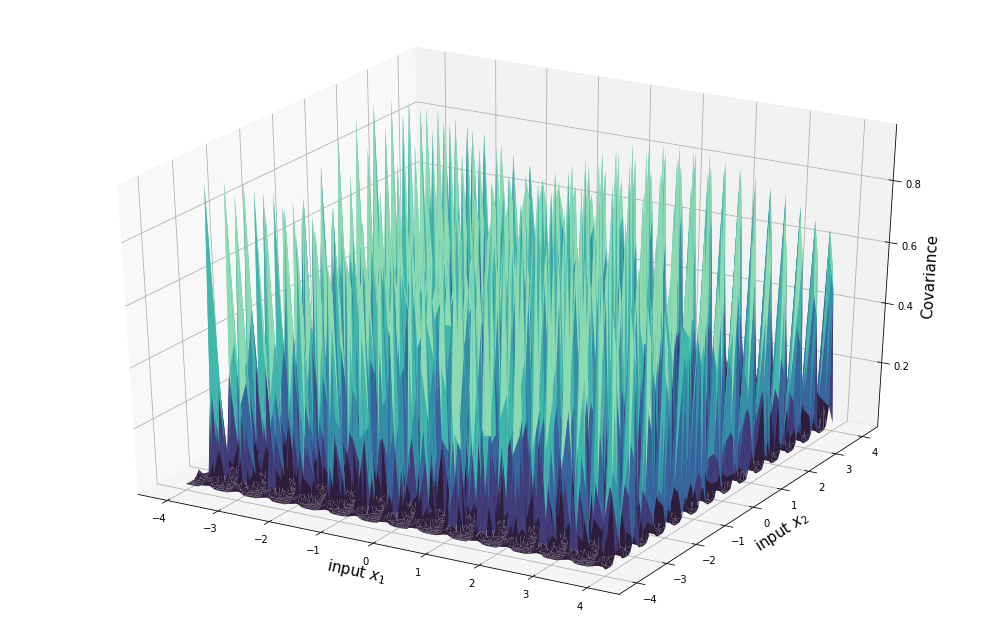

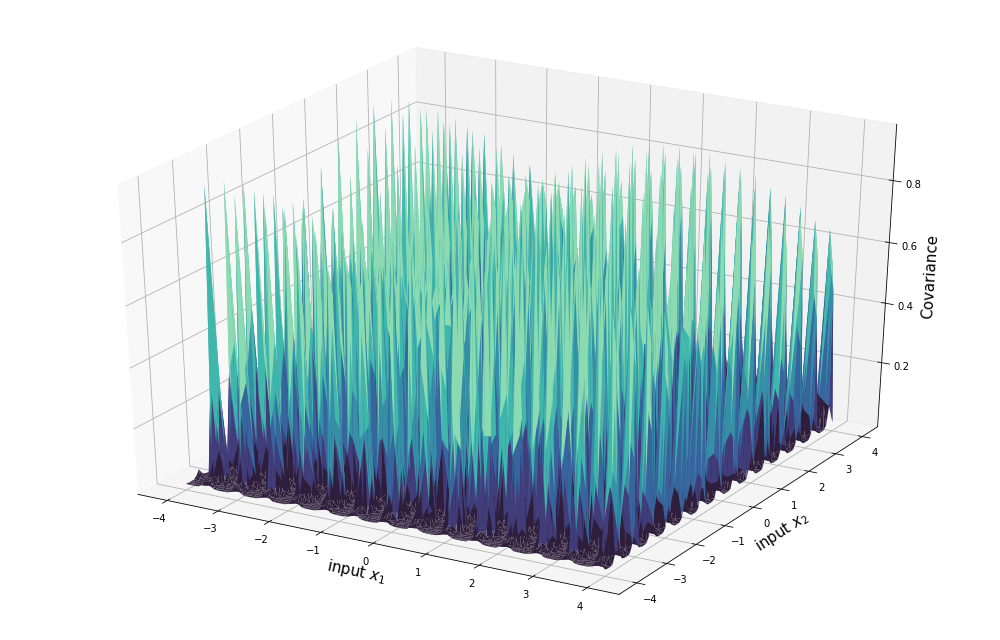

In [27]:
# plotting the main kernel
plot_kern(k)

In [ ]:
# plotting the rest of the kernels
kernels = [k1, k2, k3]
for kernel in kernels:
    plot_kern(kernel)

In [28]:
# creating a grid
[Xi, Xj] = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100)) #raise this in the final stage
# transforming our grid to a list of coordinates
Xnew = np.vstack((Xi.ravel(), Xj.ravel())).T # Change our input grid to list of coordinates

In [29]:
# calculating the mean and the covariance at the grid
mean, Cov = m.predict_noiseless(Xnew, full_cov=False)

GP_regression.,value,constraints,priors
mul.std_periodic.variance,0.9499998997260511,+ve,
mul.std_periodic.period,0.5743798602119479,+ve,
mul.std_periodic.lengthscale,0.29774679388302877,+ve,
mul.rbf.variance,1.0087587691550093,+ve,
mul.rbf.lengthscale,"(2,)",+ve,
Gaussian_noise.variance,0.05,+ve fixed,


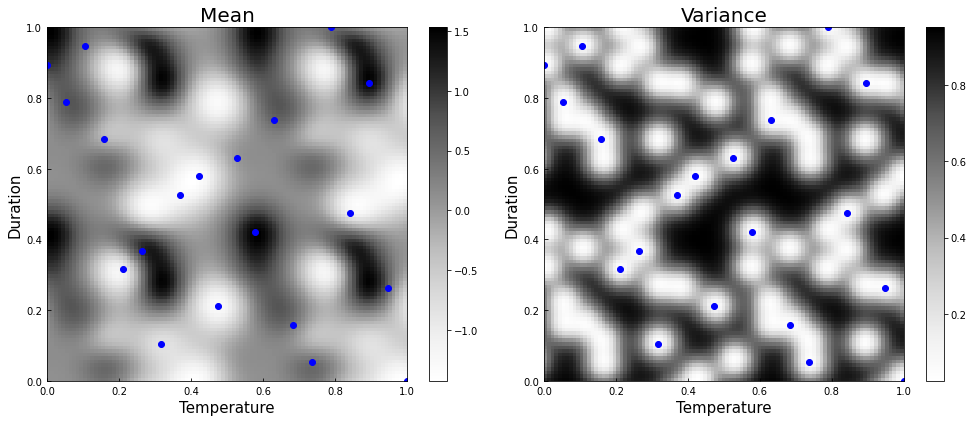

In [73]:
# plotting the mean and the variance of the gp

plt.figure(figsize=(14, 6))
my_cmap_b="Greys" # Greys

# left plot - mean of gp fit
plt.subplot(121)

# mean surface
plt.pcolor(Xi, Xj, mean.reshape(Xi.shape), cmap=my_cmap_b)

# sample locations
plt.plot(Xtrain[:, 0], Xtrain[:, 1], 'o', color='blue')
#plt.plot(Xtest[:,0], Xtest[:,1], 'o', color='red')

# annotations
plt.xlabel("Temperature", fontsize=15), plt.ylabel("Duration", fontsize=15)
plt.title("Mean", fontsize=20), 
plt.colorbar()

plt.tick_params(axis='both', which='both', labelsize=10, direction="in", pad=5)

# right plot - variance of the gp
plt.subplot(122)

# variance surface
plt.pcolor(Xi, Xj, Cov.reshape(Xi.shape), cmap=my_cmap_b)

# sample locations
plt.plot(Xtrain[:,0], Xtrain[:,1], 'o', color='blue')
#plt.plot(Xtest[:,0], Xtest[:,1], 'o', color='red')

# annotations
plt.xlabel("Temperature", fontsize=15), plt.ylabel("Duration", fontsize=15)
plt.title("Variance", fontsize=20), 
plt.colorbar()

plt.tight_layout()
plt.tick_params(axis='both', which='both', labelsize=10, direction="in", pad=5)
plt.savefig(r"C:\Users\mikep\Desktop\thesis\figures\mean-variance.png", facecolor='w', dpi=600)

m

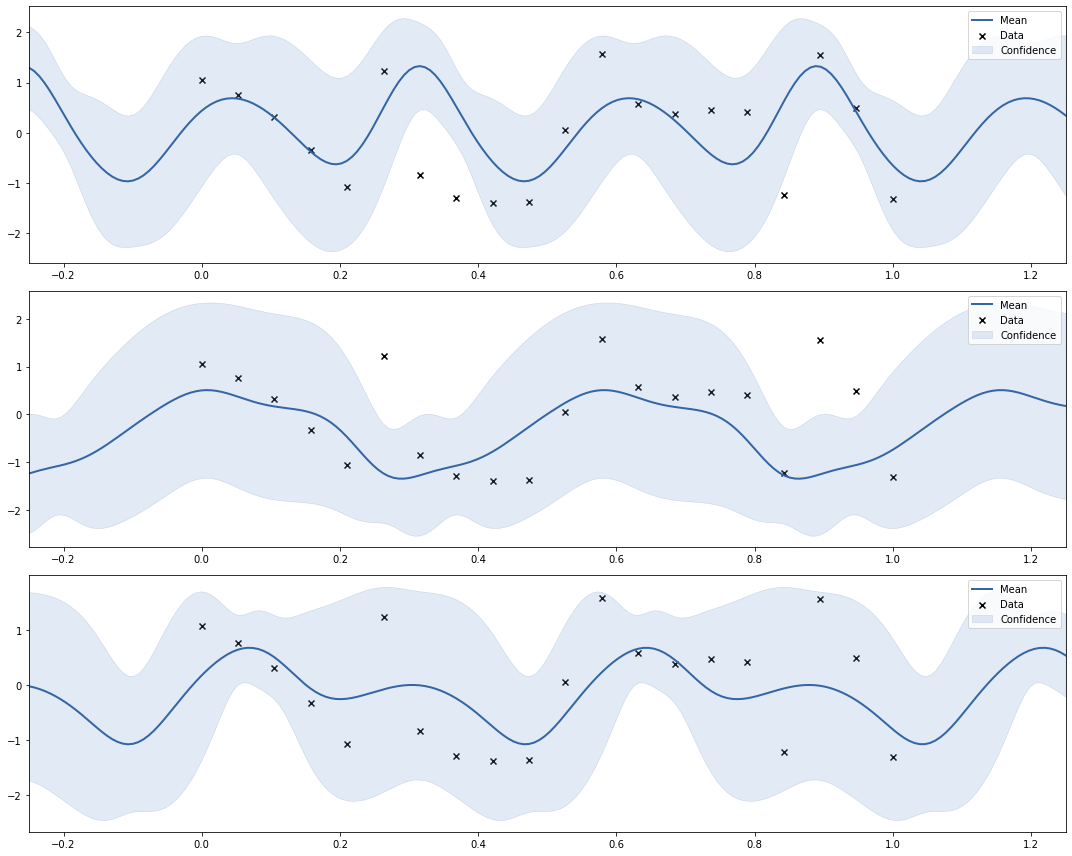

In [49]:
slices = [0.25, 0.5, 0.75]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(15,12))

for i, y in zip(range(3), slices):
    canvas = m.plot(figure=figure, fixed_inputs=[(1, y)], row=(i+1), plot_data=True)

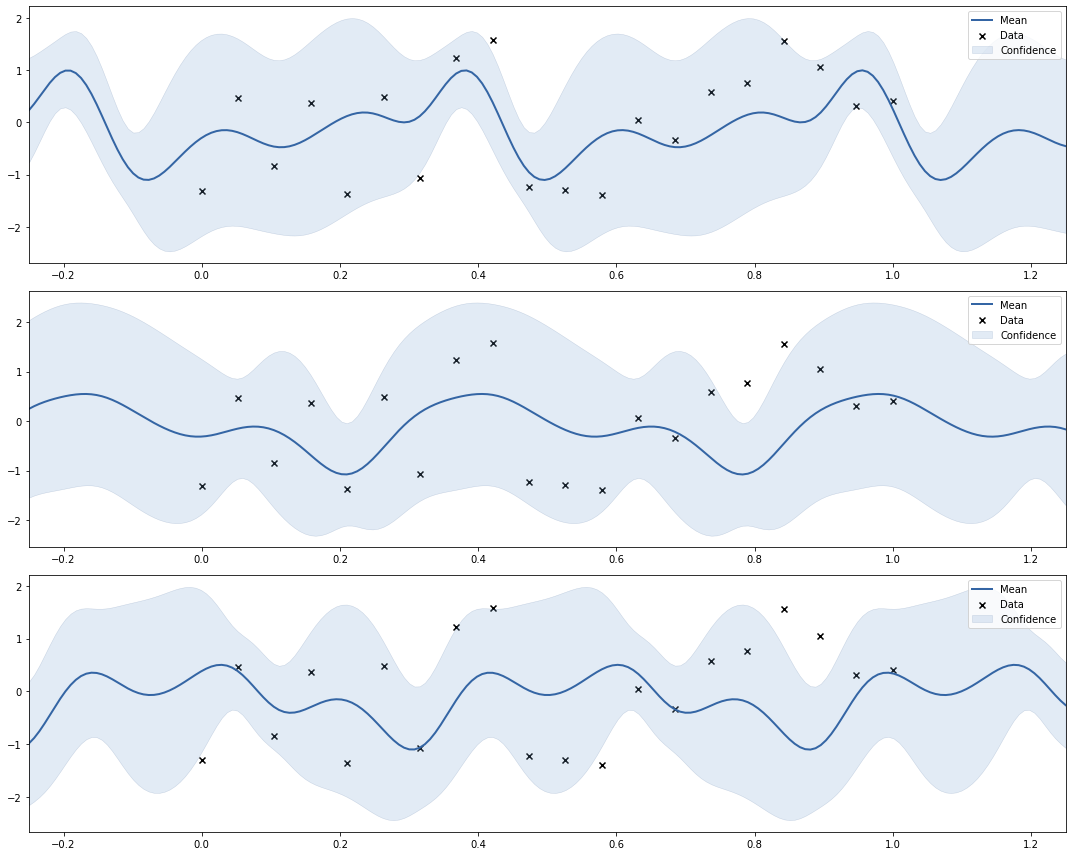

In [37]:
slices = [0.25, 0.5, 0.75]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(15,12))

for i, y in zip(range(3), slices):
    canvas = m.plot(figure=figure, fixed_inputs=[(0, y)], row=(i+1), plot_data=True)

In [ ]:
# evaluating the model with certain metrics

In [ ]:
# comparing the models